# PyTorch Classifier Benchmark

```{contents}
```

This is a basic implementation of a deep learning architecture using PyTorch in python3.10. 

This is meant to be a sandbox for Pytorch wizards to build on top of.

Nevertheless, here we describe the following MLP:

Input -> Hidden Layer 1 -> Activation -> Hidden Layer 2 -> Activation -> Output Layer

## Load data

In [1]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=0)

## Preprocess data

### Exclude categories with <10 samples

In [2]:
# exclude the samples with mixed phenotypes and Down syndrome and t(9;22)(q34.1;q11.2)/BCR::ABL1
df = df[~df['ELN AML 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
                                       'Myeloid leukaemia associated with Down syndrome',
                                       'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]

df['ELN AML 2022 Diagnosis'].value_counts()

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                           360
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11             201
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                                198
AML with other rare recurring translocations                              172
AML with mutated NPM1                                                     172
MDS-related or secondary myeloid neoplasms                                148
Otherwise-Normal Control                                                  121
AML with in-frame bZIP mutated CEBPA                                       69
APL with t(15;17)(q24.1;q21.2)/PML::RARA                                   31
AML with t(6;9)(p23;q34.1)/DEK::NUP214                                     27
AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement     10
Name: count, dtype: int64

### Exclude samples with missing labels

In [3]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df = df[~df['ELN AML 2022 Diagnosis'].isna()]

### Define X and y

In [4]:

# Define X and y
X = df[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']].to_numpy() # shape (n_samples=1399, n_features=5)
y = df['ELN AML 2022 Diagnosis'].to_numpy() # shape (n_samples=1399,) with 11 string classes

### Encode labels

In [5]:
# One hot encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# The LabelEncoder converts each unique string value into a unique integer
# For example, if we had ['cat', 'dog', 'cat', 'bird'], it could become [0, 1, 0, 2]
# The specific integer assigned to each string is arbitrary
integer_encoded = label_encoder.fit_transform(y)

# Instantiate the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# The OneHotEncoder takes column-wise inputs, so we need to reshape our 1D array to be 2D
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

# The OneHotEncoder converts each unique integer value into a unique one-hot vector
# For example, if we had [0, 1, 0, 2], it could become [[1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 0, 1]]
# The i-th index is "hot" (1) while the others are "cold" (0)
y = onehot_encoder.fit_transform(integer_encoded)


/home/fmarchi/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Define model architecture

In [6]:
import torch

# Split the data into train/test sets based on the `Train Test` column
train_indices = df['Train Test'] == 'Discovery (train) Samples'
test_indices = df['Train Test'] == 'Validation (test) Samples'

# Convert numpy arrays into PyTorch tensors
X_train = torch.tensor(X[train_indices], dtype=torch.float32)
y_train = torch.tensor(y[train_indices], dtype=torch.float32)
X_test = torch.tensor(X[test_indices], dtype=torch.float32)
y_test = torch.tensor(y[test_indices], dtype=torch.float32)



In [7]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tqdm
import copy

class Multiclass(nn.Module):
    def __init__(self, input_size=5, hidden_sizes=[10, 20],
                 output_size=11, activation=nn.ReLU()):
        
        super().__init__()
        self.layers = nn.ModuleList()
        
        # Add input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Add hidden layers
        for k in range(len(hidden_sizes) - 1):
            self.layers.append(activation)
            self.layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k + 1]))
        
        # Add output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# loss metric and optimizer
model = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 100
batch_size = 5
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []


# training loop
for epoch in (range(n_epochs)):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 279/279 [00:00<00:00, 480.17batch/s, acc=0.4, loss=2.16] 


Epoch 0 validation: Cross-entropy=0.65, Accuracy=85.5%


Epoch 1: 100%|██████████| 279/279 [00:00<00:00, 651.02batch/s, acc=0.4, loss=2.06] 


Epoch 1 validation: Cross-entropy=0.58, Accuracy=84.5%


Epoch 2: 100%|██████████| 279/279 [00:00<00:00, 684.00batch/s, acc=0.4, loss=1.97] 


Epoch 2 validation: Cross-entropy=0.55, Accuracy=84.5%


Epoch 3: 100%|██████████| 279/279 [00:00<00:00, 665.64batch/s, acc=0.4, loss=1.88] 


Epoch 3 validation: Cross-entropy=0.52, Accuracy=84.5%


Epoch 4: 100%|██████████| 279/279 [00:00<00:00, 693.08batch/s, acc=0.4, loss=1.8]  


Epoch 4 validation: Cross-entropy=0.50, Accuracy=84.5%


Epoch 5: 100%|██████████| 279/279 [00:00<00:00, 702.79batch/s, acc=0.4, loss=1.73] 


Epoch 5 validation: Cross-entropy=0.48, Accuracy=84.5%


Epoch 6: 100%|██████████| 279/279 [00:00<00:00, 681.31batch/s, acc=0.4, loss=1.67] 


Epoch 6 validation: Cross-entropy=0.47, Accuracy=84.5%


Epoch 7: 100%|██████████| 279/279 [00:00<00:00, 705.88batch/s, acc=0.4, loss=1.62] 


Epoch 7 validation: Cross-entropy=0.46, Accuracy=84.5%


Epoch 8: 100%|██████████| 279/279 [00:00<00:00, 708.14batch/s, acc=0.4, loss=1.58] 


Epoch 8 validation: Cross-entropy=0.45, Accuracy=84.5%


Epoch 9: 100%|██████████| 279/279 [00:00<00:00, 663.13batch/s, acc=0.4, loss=1.55] 


Epoch 9 validation: Cross-entropy=0.44, Accuracy=84.5%


Epoch 10: 100%|██████████| 279/279 [00:00<00:00, 704.78batch/s, acc=0.4, loss=1.52] 


Epoch 10 validation: Cross-entropy=0.43, Accuracy=83.6%


Epoch 11: 100%|██████████| 279/279 [00:00<00:00, 658.70batch/s, acc=0.4, loss=1.49] 


Epoch 11 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 12: 100%|██████████| 279/279 [00:00<00:00, 592.74batch/s, acc=0.2, loss=1.47] 


Epoch 12 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 13: 100%|██████████| 279/279 [00:00<00:00, 617.34batch/s, acc=0.2, loss=1.45] 


Epoch 13 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 14: 100%|██████████| 279/279 [00:00<00:00, 680.71batch/s, acc=0.2, loss=1.44] 


Epoch 14 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 15: 100%|██████████| 279/279 [00:00<00:00, 599.46batch/s, acc=0.2, loss=1.43] 


Epoch 15 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 16: 100%|██████████| 279/279 [00:00<00:00, 573.86batch/s, acc=0.2, loss=1.42] 


Epoch 16 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 17: 100%|██████████| 279/279 [00:00<00:00, 481.18batch/s, acc=0.2, loss=1.41] 


Epoch 17 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 18: 100%|██████████| 279/279 [00:00<00:00, 558.92batch/s, acc=0.2, loss=1.41] 


Epoch 18 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 19: 100%|██████████| 279/279 [00:00<00:00, 608.92batch/s, acc=0.2, loss=1.39] 


Epoch 19 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 20: 100%|██████████| 279/279 [00:00<00:00, 645.18batch/s, acc=0.2, loss=1.37] 


Epoch 20 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 21: 100%|██████████| 279/279 [00:00<00:00, 676.10batch/s, acc=0.2, loss=1.36] 


Epoch 21 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 22: 100%|██████████| 279/279 [00:00<00:00, 669.53batch/s, acc=0.2, loss=1.36] 


Epoch 22 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 23: 100%|██████████| 279/279 [00:00<00:00, 657.96batch/s, acc=0.2, loss=1.32] 


Epoch 23 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 24: 100%|██████████| 279/279 [00:00<00:00, 666.84batch/s, acc=0.2, loss=1.3]  


Epoch 24 validation: Cross-entropy=0.42, Accuracy=82.7%


Epoch 25: 100%|██████████| 279/279 [00:00<00:00, 660.64batch/s, acc=0.4, loss=1.27] 


Epoch 25 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 26: 100%|██████████| 279/279 [00:00<00:00, 689.98batch/s, acc=0.4, loss=1.25] 


Epoch 26 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 27: 100%|██████████| 279/279 [00:00<00:00, 702.45batch/s, acc=0.4, loss=1.24] 


Epoch 27 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 28: 100%|██████████| 279/279 [00:00<00:00, 625.12batch/s, acc=0.4, loss=1.23] 


Epoch 28 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 29: 100%|██████████| 279/279 [00:00<00:00, 554.66batch/s, acc=0.4, loss=1.21] 


Epoch 29 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 30: 100%|██████████| 279/279 [00:00<00:00, 554.39batch/s, acc=0.4, loss=1.2]  


Epoch 30 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 31: 100%|██████████| 279/279 [00:00<00:00, 677.19batch/s, acc=0.4, loss=1.19] 


Epoch 31 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 32: 100%|██████████| 279/279 [00:00<00:00, 700.19batch/s, acc=0.4, loss=1.17] 


Epoch 32 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 33: 100%|██████████| 279/279 [00:00<00:00, 576.73batch/s, acc=0.4, loss=1.17] 


Epoch 33 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 34: 100%|██████████| 279/279 [00:00<00:00, 591.24batch/s, acc=0.4, loss=1.15] 


Epoch 34 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 35: 100%|██████████| 279/279 [00:00<00:00, 608.25batch/s, acc=0.4, loss=1.14] 


Epoch 35 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 36: 100%|██████████| 279/279 [00:00<00:00, 598.95batch/s, acc=0.4, loss=1.14] 


Epoch 36 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 37: 100%|██████████| 279/279 [00:00<00:00, 606.07batch/s, acc=0.4, loss=1.12] 


Epoch 37 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 38: 100%|██████████| 279/279 [00:00<00:00, 572.82batch/s, acc=0.4, loss=1.12] 


Epoch 38 validation: Cross-entropy=0.43, Accuracy=82.7%


Epoch 39: 100%|██████████| 279/279 [00:00<00:00, 560.99batch/s, acc=0.4, loss=1.12] 


Epoch 39 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 40: 100%|██████████| 279/279 [00:00<00:00, 576.58batch/s, acc=0.4, loss=1.1]  


Epoch 40 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 41: 100%|██████████| 279/279 [00:00<00:00, 549.90batch/s, acc=0.4, loss=1.1]  


Epoch 41 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 42: 100%|██████████| 279/279 [00:00<00:00, 579.89batch/s, acc=0.6, loss=1.09] 


Epoch 42 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 43: 100%|██████████| 279/279 [00:00<00:00, 566.64batch/s, acc=0.6, loss=1.08] 


Epoch 43 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 44: 100%|██████████| 279/279 [00:00<00:00, 563.72batch/s, acc=0.6, loss=1.07] 


Epoch 44 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 45: 100%|██████████| 279/279 [00:00<00:00, 565.02batch/s, acc=0.6, loss=1.06] 


Epoch 45 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 46: 100%|██████████| 279/279 [00:00<00:00, 555.50batch/s, acc=0.6, loss=1.06] 


Epoch 46 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 47: 100%|██████████| 279/279 [00:00<00:00, 556.12batch/s, acc=0.6, loss=1.06] 


Epoch 47 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 48: 100%|██████████| 279/279 [00:00<00:00, 558.99batch/s, acc=0.6, loss=1.04] 


Epoch 48 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 49: 100%|██████████| 279/279 [00:00<00:00, 561.69batch/s, acc=0.6, loss=1.04] 


Epoch 49 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 50: 100%|██████████| 279/279 [00:00<00:00, 562.00batch/s, acc=0.6, loss=1.04] 


Epoch 50 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 51: 100%|██████████| 279/279 [00:00<00:00, 560.62batch/s, acc=0.6, loss=1.03] 


Epoch 51 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 52: 100%|██████████| 279/279 [00:00<00:00, 564.23batch/s, acc=0.6, loss=1.03] 


Epoch 52 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 53: 100%|██████████| 279/279 [00:00<00:00, 559.37batch/s, acc=0.6, loss=1.02] 


Epoch 53 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 54: 100%|██████████| 279/279 [00:00<00:00, 572.43batch/s, acc=0.6, loss=1.02] 


Epoch 54 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 55: 100%|██████████| 279/279 [00:00<00:00, 570.09batch/s, acc=0.6, loss=1.02] 


Epoch 55 validation: Cross-entropy=0.44, Accuracy=82.7%


Epoch 56: 100%|██████████| 279/279 [00:00<00:00, 547.56batch/s, acc=0.6, loss=1.01] 


Epoch 56 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 57: 100%|██████████| 279/279 [00:00<00:00, 549.49batch/s, acc=0.6, loss=1]    


Epoch 57 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 58: 100%|██████████| 279/279 [00:00<00:00, 555.71batch/s, acc=0.6, loss=0.999]


Epoch 58 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 59: 100%|██████████| 279/279 [00:00<00:00, 554.20batch/s, acc=0.6, loss=0.993]


Epoch 59 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 60: 100%|██████████| 279/279 [00:00<00:00, 594.50batch/s, acc=0.6, loss=0.988]


Epoch 60 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 61: 100%|██████████| 279/279 [00:00<00:00, 590.29batch/s, acc=0.6, loss=0.984]


Epoch 61 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 62: 100%|██████████| 279/279 [00:00<00:00, 610.14batch/s, acc=0.6, loss=0.978]


Epoch 62 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 63: 100%|██████████| 279/279 [00:00<00:00, 579.75batch/s, acc=0.6, loss=0.974]


Epoch 63 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 64: 100%|██████████| 279/279 [00:00<00:00, 551.75batch/s, acc=0.6, loss=0.969]


Epoch 64 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 65: 100%|██████████| 279/279 [00:00<00:00, 560.96batch/s, acc=0.6, loss=0.966]


Epoch 65 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 66: 100%|██████████| 279/279 [00:00<00:00, 562.02batch/s, acc=0.6, loss=0.96] 


Epoch 66 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 67: 100%|██████████| 279/279 [00:00<00:00, 561.21batch/s, acc=0.6, loss=0.955]


Epoch 67 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 68: 100%|██████████| 279/279 [00:00<00:00, 560.97batch/s, acc=0.6, loss=0.949]


Epoch 68 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 69: 100%|██████████| 279/279 [00:00<00:00, 570.75batch/s, acc=0.6, loss=0.946]


Epoch 69 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 70: 100%|██████████| 279/279 [00:00<00:00, 583.84batch/s, acc=0.6, loss=0.941]


Epoch 70 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 71: 100%|██████████| 279/279 [00:00<00:00, 545.81batch/s, acc=0.6, loss=0.94] 


Epoch 71 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 72: 100%|██████████| 279/279 [00:00<00:00, 567.81batch/s, acc=0.6, loss=0.936]


Epoch 72 validation: Cross-entropy=0.45, Accuracy=83.6%


Epoch 73: 100%|██████████| 279/279 [00:00<00:00, 556.51batch/s, acc=0.6, loss=0.935]


Epoch 73 validation: Cross-entropy=0.45, Accuracy=82.7%


Epoch 74: 100%|██████████| 279/279 [00:00<00:00, 555.46batch/s, acc=0.6, loss=0.931]


Epoch 74 validation: Cross-entropy=0.45, Accuracy=83.6%


Epoch 75: 100%|██████████| 279/279 [00:00<00:00, 571.36batch/s, acc=0.6, loss=0.931]


Epoch 75 validation: Cross-entropy=0.45, Accuracy=83.6%


Epoch 76: 100%|██████████| 279/279 [00:00<00:00, 579.01batch/s, acc=0.6, loss=0.93] 


Epoch 76 validation: Cross-entropy=0.45, Accuracy=83.6%


Epoch 77: 100%|██████████| 279/279 [00:00<00:00, 557.20batch/s, acc=0.6, loss=0.926]


Epoch 77 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 78: 100%|██████████| 279/279 [00:00<00:00, 518.04batch/s, acc=0.6, loss=0.925]


Epoch 78 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 79: 100%|██████████| 279/279 [00:00<00:00, 540.65batch/s, acc=0.6, loss=0.925]


Epoch 79 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 80: 100%|██████████| 279/279 [00:00<00:00, 507.77batch/s, acc=0.6, loss=0.924]


Epoch 80 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 81: 100%|██████████| 279/279 [00:00<00:00, 547.10batch/s, acc=0.6, loss=0.921]


Epoch 81 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 82: 100%|██████████| 279/279 [00:00<00:00, 539.85batch/s, acc=0.6, loss=0.921]


Epoch 82 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 83: 100%|██████████| 279/279 [00:00<00:00, 552.53batch/s, acc=0.6, loss=0.921]


Epoch 83 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 84: 100%|██████████| 279/279 [00:00<00:00, 538.57batch/s, acc=0.6, loss=0.923]


Epoch 84 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 85: 100%|██████████| 279/279 [00:00<00:00, 564.98batch/s, acc=0.6, loss=0.923]


Epoch 85 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 86: 100%|██████████| 279/279 [00:00<00:00, 582.71batch/s, acc=0.6, loss=0.923]


Epoch 86 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 87: 100%|██████████| 279/279 [00:00<00:00, 570.07batch/s, acc=0.6, loss=0.924]


Epoch 87 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 88: 100%|██████████| 279/279 [00:00<00:00, 525.69batch/s, acc=0.6, loss=0.923]


Epoch 88 validation: Cross-entropy=0.45, Accuracy=87.3%


Epoch 89: 100%|██████████| 279/279 [00:00<00:00, 539.69batch/s, acc=0.6, loss=0.923]


Epoch 89 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 90: 100%|██████████| 279/279 [00:00<00:00, 572.44batch/s, acc=0.6, loss=0.923]


Epoch 90 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 91: 100%|██████████| 279/279 [00:00<00:00, 556.88batch/s, acc=0.6, loss=0.924]


Epoch 91 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 92: 100%|██████████| 279/279 [00:00<00:00, 558.47batch/s, acc=0.6, loss=0.923]


Epoch 92 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 93: 100%|██████████| 279/279 [00:00<00:00, 556.46batch/s, acc=0.6, loss=0.926]


Epoch 93 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 94: 100%|██████████| 279/279 [00:00<00:00, 571.31batch/s, acc=0.6, loss=0.926]


Epoch 94 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 95: 100%|██████████| 279/279 [00:00<00:00, 555.42batch/s, acc=0.6, loss=0.929]


Epoch 95 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 96: 100%|██████████| 279/279 [00:00<00:00, 539.74batch/s, acc=0.6, loss=0.927]


Epoch 96 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 97: 100%|██████████| 279/279 [00:00<00:00, 532.53batch/s, acc=0.6, loss=0.927]


Epoch 97 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 98: 100%|██████████| 279/279 [00:00<00:00, 521.84batch/s, acc=0.6, loss=0.928]


Epoch 98 validation: Cross-entropy=0.46, Accuracy=87.3%


Epoch 99: 100%|██████████| 279/279 [00:00<00:00, 550.98batch/s, acc=0.6, loss=0.928]


Epoch 99 validation: Cross-entropy=0.46, Accuracy=87.3%


<All keys matched successfully>

## Plot model performance

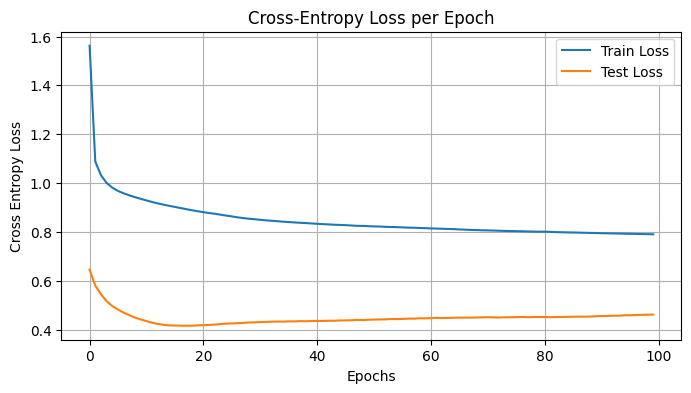

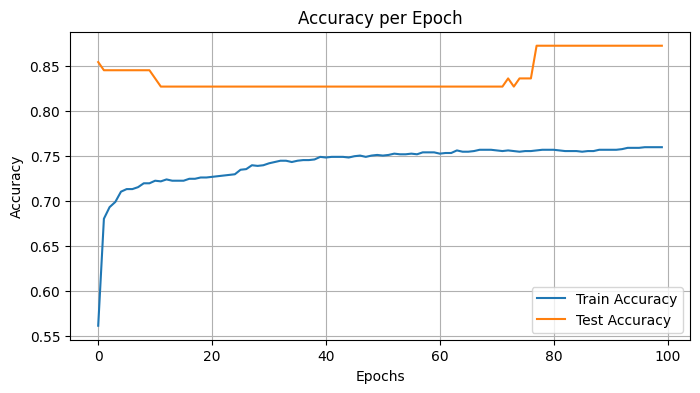

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# Plotting the Cross-Entropy Loss
plt.figure(figsize=(8, 4))
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.title("Cross-Entropy Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the Accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Confusion matrices

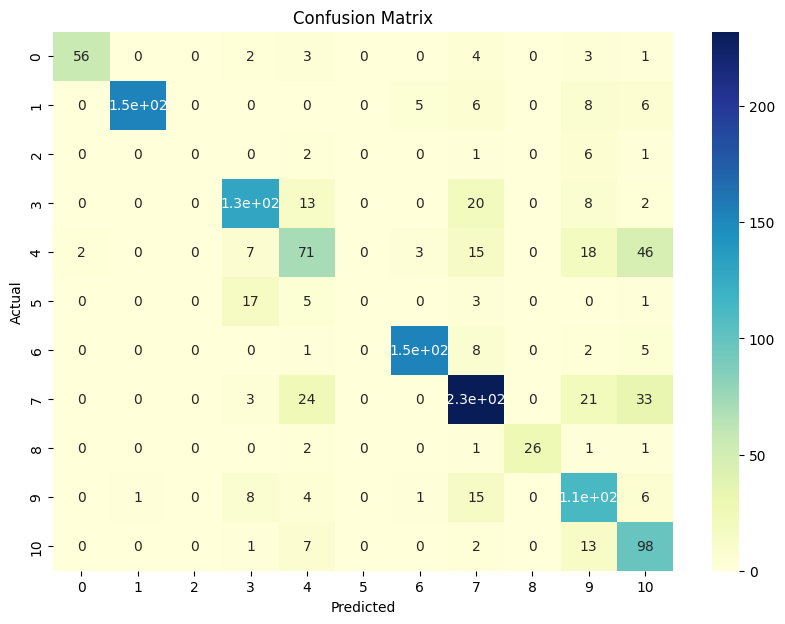

ValueError: Shape of passed values is (9, 9), indices imply (7, 7)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch

def plot_confusion_matrix(y_true, y_pred, output_size):
    model.eval()
    _, y_pred = torch.max(model(y_pred), 1)
    conf_mat = confusion_matrix(y_true.numpy(), y_pred.numpy())
    df_cm = pd.DataFrame(conf_mat, index=[i for i in range(output_size)],
                         columns=[i for i in range(output_size)])
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
output_sizes = [11, 7]  # Replace with actual output sizes if different
data = [(y_train, X_train), (y_test, X_test)]  # Your data tuples here

for i in range(2):
    _, y_true = torch.max(data[i][0], 1)
    plot_confusion_matrix(y_true, data[i][1], output_sizes[i])


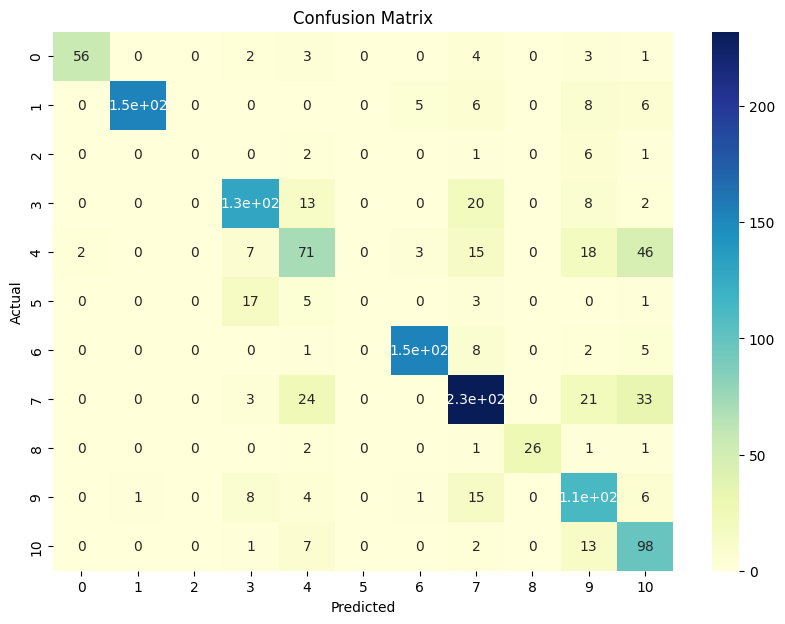

ValueError: Shape of passed values is (9, 9), indices imply (7, 7)

In [10]:
# Convert one-hot encoded targets back to class labels
_, y_train_labels = torch.max(y_train, 1)
# Define the number of classes (replace 11 with the actual number if different)
output_size = 11
# Compute the confusion matrix
model.eval()
y_pred = model(X_train)
_, y_pred = torch.max(y_pred, 1)

conf_mat = confusion_matrix(y_train_labels.numpy(), y_pred.numpy())
df_cm = pd.DataFrame(conf_mat, index = [i for i in range(output_size)],
                     columns = [i for i in range(output_size)])

# Plot the confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Convert one-hot encoded targets back to class labels
_, y_test_labels = torch.max(y_test, 1)
# Define the number of classes (replace 11 with the actual number if different)
output_size = 7
# Compute the confusion matrix
model.eval()
y_pred = model(X_test)
_, y_pred = torch.max(y_pred, 1)

conf_mat = confusion_matrix(y_test_labels.numpy(), y_pred.numpy())
df_cm = pd.DataFrame(conf_mat, index = [i for i in range(output_size)],
                     columns = [i for i in range(output_size)])

# Plot the confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Watermark

In [34]:
# Add watermark with all packages used
get_ipython().run_line_magic('load_ext', 'watermark')

In [35]:
get_ipython().run_line_magic('watermark', '-v -m -p numpy,pandas,torch,sklearn,seaborn,matplotlib -a Francisco_Marchi@Lamba_Lab_UF')

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.14.0

numpy     : 1.24.1
pandas    : 2.0.2
torch     : 2.0.1+cu118
sklearn   : 1.2.2
seaborn   : 0.12.2
matplotlib: 3.7.1

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

